<a href="https://colab.research.google.com/github/MartinNde/MartinN_1/blob/main/Time_Series_Competition_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the packages#

In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist
import seaborn as sns
sns.set()


#Importing the Data#

In [379]:
raw_csv_data = pd.read_csv('/content/PT_Train.csv')

In [380]:
df = raw_csv_data.copy()

###view the data to have an understanding of the structure###

In [381]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


###attempt to view the entire data to see if something strange stands out###

In [382]:
df

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0
...,...,...,...,...,...
221,17/08/2015 18:50,159,51,NaN,NaN
222,17/08/2015 18:51,151,64,NaN,NaN
223,17/08/2015 18:52,140,64,NaN,NaN
224,17/08/2015 18:53,140,55,NaN,NaN


In [383]:
print(df.shape)
df.head()

(226, 5)


,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [384]:
df.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,226.000000,226.000000,191.000000,191.000000
mean,2315.615044,2219.216814,83.450262,126.335079
std,11351.588825,11370.093548,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,145.000000,46.000000,93.000000,139.000000
75%,156.000000,53.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


In [385]:
df.isna().sum()

Timestamp (GMT)                0
Lifetouch Heart Rate           0
Lifetouch Respiration Rate     0
Oximeter SpO2                 35
Oximeter Pulse                35
dtype: int64

Simpliyfing the Dataset

In [386]:
df = df.drop(['Lifetouch Respiration Rate','Oximeter SpO2','Oximeter Pulse'], axis=1)



In [387]:
df.describe()

,Lifetouch Heart Rate
count,226.000000
mean,2315.615044
std,11351.588825
min,106.000000
25%,136.000000
50%,145.000000
75%,156.000000
max,61442.000000


In [388]:
df.isna().sum()

Timestamp (GMT)         0
Lifetouch Heart Rate    0
dtype: int64

Setting the index

In [389]:
df.set_index("Timestamp (GMT)", inplace = True)

In [390]:
df

,Lifetouch Heart Rate
Timestamp (GMT),
17/08/2015 15:09,139
17/08/2015 15:10,144
17/08/2015 15:11,140
17/08/2015 15:12,138
17/08/2015 15:13,133
...,...
17/08/2015 18:50,159
17/08/2015 18:51,151
17/08/2015 18:52,140


Splitting Data - An 80/20 split is reasonable

In [391]:
df_train = df.iloc[:size]

In [392]:
df_test = df.iloc[size:]

In [393]:
df.tail()

,Lifetouch Heart Rate
Timestamp (GMT),
17/08/2015 18:50,159
17/08/2015 18:51,151
17/08/2015 18:52,140
17/08/2015 18:53,140
17/08/2015 18:54,138


In [394]:
df_test.head()

,Lifetouch Heart Rate
Timestamp (GMT),
17/08/2015 15:09,139
17/08/2015 15:10,144
17/08/2015 15:11,140
17/08/2015 15:12,138
17/08/2015 15:13,133


##Plot the time series##

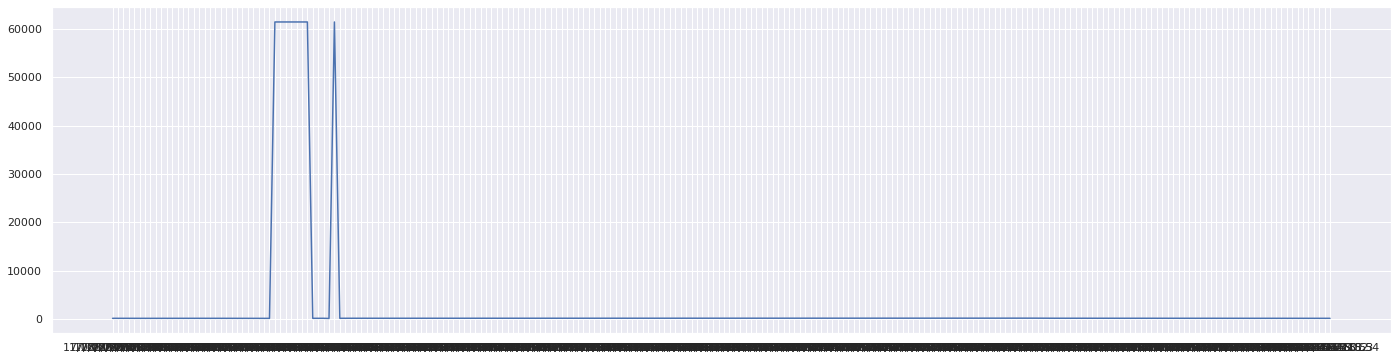

In [397]:
plt.figure(figsize =(24,6))
plt.plot(df.index,df['Lifetouch Heart Rate'])
plt.show()

Check stationarity of the series

In [399]:
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [400]:
check_stationarity(df['Lifetouch Heart Rate'])

p value: 0.1
Result: The series is stationary 



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [403]:
single_fit = SimpleExpSmoothing(df["Lifetouch Heart Rate"]).fit()
double_fit = Holt(df["Lifetouch Heart Rate"]).fit()
tripple_fit = ExponentialSmoothing(df["Lifetouch Heart Rate"], trend="mul",seasonal="mul", seasonal_periods=12).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
/usr/local/l

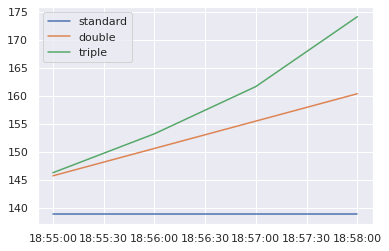

In [408]:
# future predictions
predictions_single_fit = single_fit.forecast(4)
predictions_double_fit = double_fit.forecast(4)
predictions_tripple_fit = tripple_fit.forecast(4)


plt.plot(predictions_single_fit, label='standard')
plt.plot(predictions_double_fit, label='double')
plt.plot(predictions_tripple_fit, label='triple')

plt.legend()
plt.show()